# Validación de Resultados del Pipeline de Análisis Semántico

**Tesis**: Análisis comparativo de políticas públicas sobre educación en IA  
**Autor**: Hesus García Cobos — Maestría en Pedagogía, UPAEP

---

## Objetivo

Validar que los resultados del pipeline (chunks → embeddings → similitud → clustering) sean confiables antes de la defensa.

## Metodología: 3 Perspectivas de Experto × 6 Rondas

| Ronda | Perspectiva | Foco |
|-------|-------------|------|
| R1 | CS Expert | Auditoría de datos: chunks, embeddings, matriz |
| R2 | AI Engineer | Relevancia de búsqueda semántica |
| R3 | Policy Expert | Validación de contenido temático |
| R4 | AI Engineer | Sensibilidad de parámetros |
| R5 | AI Engineer | Comparación de modelos de embedding |
| R6 | CS + AI | Estrategias de agregación |

Cada ronda termina con **VEREDICTO** (PASS / WARN / FAIL) y un resumen compacto acumulativo.

In [1]:
# Cell 2 — Imports and paths
import sys, os, json, warnings
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

# Project root (one level up from pipeline/)
PROJECT_ROOT = Path(os.getcwd()).parent if Path(os.getcwd()).name == "pipeline" else Path(os.getcwd())
sys.path.insert(0, str(PROJECT_ROOT))

from pipeline.config import (
    CHROMA_DIR, COLLECTION_NAME, CHUNK_SIZE, CHUNK_OVERLAP,
    DIMENSIONS, COUNTRIES, REGION_COLORS, PROCESSED_DIR, METADATA_FILE,
    OPENAI_API_KEY, EMBEDDING_MODEL_LOCAL, EMBEDDING_MODEL_OPENAI,
)
from pipeline.ingest import chunk_text, load_metadata, read_processed_file
from pipeline.embeddings import get_embedding_function
from pipeline.similarity import get_collection, get_policy_embedding, compute_similarity_matrix
from pipeline.analysis import hierarchical_clustering

print(f"Project root: {PROJECT_ROOT}")
print(f"ChromaDB dir: {CHROMA_DIR}")
print(f"Chunk config: size={CHUNK_SIZE}, overlap={CHUNK_OVERLAP}")
print(f"Dimensions: {len(DIMENSIONS)}")
print(f"Embedding model (local): {EMBEDDING_MODEL_LOCAL}")

Project root: /mnt/c/Users/HG_Co/OneDrive/Documents/Github/tesis-hesusg-pedadogia
ChromaDB dir: /mnt/c/Users/HG_Co/OneDrive/Documents/Github/tesis-hesusg-pedadogia/.chroma_db
Chunk config: size=800, overlap=200
Dimensions: 7
Embedding model (local): paraphrase-multilingual-MiniLM-L12-v2


In [2]:
# Cell 3 — Connect to ChromaDB + count chunks
collection = get_collection()
total_chunks = collection.count()
print(f"ChromaDB collection '{COLLECTION_NAME}': {total_chunks} chunks")

ChromaDB collection 'politicas_ia_educacion': 5120 chunks


In [3]:
# Cell 4 — Load results.json (production data)
results_path = PROJECT_ROOT / "web" / "data" / "results.json"
with open(results_path, "r", encoding="utf-8") as f:
    results = json.load(f)

prod_matrix = np.array(results["similarity_matrix"])
prod_policy_ids = results["policy_ids"]
prod_dim_scores = results["dimension_scores"]
prod_clusters = results["clusters"]
dim_labels = results["dimension_labels"]

print(f"Production data: {len(prod_policy_ids)} policies, matrix {prod_matrix.shape}")
print(f"Clusters: {len(prod_clusters)} groups")
print(f"Dimensions: {list(dim_labels.keys())}")

Production data: 14 policies, matrix (14, 14)
Clusters: 3 groups
Dimensions: ['gobernanza', 'curriculo', 'formacion_docente', 'infraestructura', 'etica', 'investigacion', 'equidad']


In [4]:
# Cell 5 — Validate API keys (graceful fallback)
api_status = {"openai_embeddings": False, "openai_gpt4o": False, "together_llama": False}

# OpenAI
if OPENAI_API_KEY:
    try:
        from openai import OpenAI
        oai_client = OpenAI(api_key=OPENAI_API_KEY)
        test_emb = oai_client.embeddings.create(input=["test"], model=EMBEDDING_MODEL_OPENAI)
        api_status["openai_embeddings"] = True
        print("OpenAI embeddings: OK")
    except Exception as e:
        print(f"OpenAI embeddings: FAIL ({e})")
    try:
        test_chat = oai_client.chat.completions.create(
            model="gpt-4o", messages=[{"role": "user", "content": "Say OK"}], max_tokens=5
        )
        api_status["openai_gpt4o"] = True
        print("OpenAI GPT-4o: OK")
    except Exception as e:
        print(f"OpenAI GPT-4o: FAIL ({e})")
else:
    print("OpenAI: no API key")

# Together AI
together_api_key = os.getenv("TOGETHER_API_KEY", "")
if together_api_key:
    try:
        from together import Together
        tog_client = Together(api_key=together_api_key)
        test_resp = tog_client.chat.completions.create(
            model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
            messages=[{"role": "user", "content": "Say OK"}], max_tokens=5
        )
        api_status["together_llama"] = True
        print("Together Llama 3.3 70B: OK")
    except Exception as e:
        print(f"Together Llama: FAIL ({e})")
else:
    print("Together: no API key")

has_llm = api_status["openai_gpt4o"] or api_status["together_llama"]
print(f"\nLLM available for judging: {has_llm}")
print(f"OpenAI embeddings for R5: {api_status['openai_embeddings']}")

OpenAI embeddings: OK
OpenAI GPT-4o: OK
Together Llama 3.3 70B: OK

LLM available for judging: True
OpenAI embeddings for R5: True


In [5]:
# Cell 6 — Load processed texts for all 14 policies
metadata = load_metadata()
policy_ids = [p["policy_id"] for p in metadata["policies"]]

policy_texts = {}
for pid in policy_ids:
    try:
        policy_texts[pid] = read_processed_file(pid)
        print(f"  {pid}: {len(policy_texts[pid]):,} chars")
    except FileNotFoundError:
        print(f"  {pid}: NOT FOUND")

print(f"\nLoaded {len(policy_texts)}/{len(policy_ids)} policy texts")

# Helper: call LLM with fallback chain
def call_llm(prompt, max_tokens=200):
    """Call GPT-4o → Llama 3.3 → keyword fallback."""
    if api_status["openai_gpt4o"]:
        resp = oai_client.chat.completions.create(
            model="gpt-4o", messages=[{"role": "user", "content": prompt}],
            max_tokens=max_tokens, temperature=0
        )
        return resp.choices[0].message.content.strip(), "gpt-4o"
    if api_status["together_llama"]:
        resp = tog_client.chat.completions.create(
            model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
            messages=[{"role": "user", "content": prompt}],
            max_tokens=max_tokens, temperature=0
        )
        return resp.choices[0].message.content.strip(), "llama-3.3-70b"
    return None, "none"

# Accumulator for verdicts
verdicts = {}

  eu_ai_act_2024: 620,051 chars
  espana_enia_2020: 169,617 chars
  francia_villani_report_2018: 423,882 chars
  alemania_ai_strategy_2018: NOT FOUND
  canada_pan_canadian_ai_strategy_2017: 6,446 chars
  brasil_ebia_2021: 132,414 chars
  colombia_conpes_3975_2019: 141,382 chars
  japon_ai_strategy_2019: 128,874 chars
  corea_ai_strategy_2019: 130,215 chars
  singapur_nais_2019: 100,468 chars
  india_aiforall_2018: 274,300 chars
  india_nep_2020: 272,976 chars
  australia_ai_action_plan_2021: 72,080 chars
  unesco_genai_guidance_2023: 165,157 chars
  wef_future_of_jobs_2020: 430,069 chars

Loaded 14/15 policy texts


---
# Ronda 1 — Auditoría de Datos (CS Expert)

**Pregunta**: ¿Los datos almacenados en ChromaDB son consistentes, completos y libres de artefactos?

In [6]:
# Cell 8 — R1.1: Chunks per policy (ChromaDB vs re-chunking)
r1_issues = []

chunk_counts_db = {}
chunk_counts_expected = {}

for pid in policy_ids:
    # Count in ChromaDB
    db_results = collection.get(where={"policy_id": pid}, include=[])
    chunk_counts_db[pid] = len(db_results["ids"])
    
    # Expected from re-chunking
    if pid in policy_texts:
        expected = chunk_text(policy_texts[pid])
        chunk_counts_expected[pid] = len(expected)
    else:
        chunk_counts_expected[pid] = -1

print(f"{'Policy':<45} {'DB':>5} {'Expected':>8} {'Match':>6}")
print("-" * 70)
for pid in policy_ids:
    db_n = chunk_counts_db[pid]
    ex_n = chunk_counts_expected[pid]
    match = "OK" if db_n == ex_n else "DIFF"
    if match == "DIFF":
        r1_issues.append(f"Chunk count mismatch for {pid}: DB={db_n}, expected={ex_n}")
    print(f"  {pid:<43} {db_n:>5} {ex_n:>8} {match:>6}")

total_db = sum(chunk_counts_db.values())
total_ex = sum(v for v in chunk_counts_expected.values() if v > 0)
print(f"\n  Total: DB={total_db}, Expected={total_ex}")

Policy                                           DB Expected  Match
----------------------------------------------------------------------
  eu_ai_act_2024                               1034     1034     OK
  espana_enia_2020                              283      283     OK
  francia_villani_report_2018                   707      707     OK
  alemania_ai_strategy_2018                       0       -1   DIFF
  canada_pan_canadian_ai_strategy_2017           11       11     OK
  brasil_ebia_2021                              221      221     OK
  colombia_conpes_3975_2019                     236      236     OK
  japon_ai_strategy_2019                        215      215     OK
  corea_ai_strategy_2019                        218      218     OK
  singapur_nais_2019                            168      168     OK
  india_aiforall_2018                           458      458     OK
  india_nep_2020                                455      455     OK
  australia_ai_action_plan_2021              

In [7]:
# Cell 9 — R1.2: Verify overlap between consecutive chunks
print("Overlap verification (expected ~200 chars shared between consecutive chunks):\n")
overlap_ok = 0
overlap_total = 0

for pid in list(policy_texts.keys())[:5]:  # Sample 5 policies
    chunks = chunk_text(policy_texts[pid])
    for i in range(len(chunks) - 1):
        overlap_total += 1
        # Find shared suffix/prefix
        c1, c2 = chunks[i], chunks[i + 1]
        # The overlap should be: end of c1 matches start of c2
        overlap_len = 0
        max_check = min(len(c1), len(c2), CHUNK_OVERLAP + 50)
        for k in range(1, max_check + 1):
            if c1[-k:] == c2[:k]:
                overlap_len = k
        if overlap_len >= CHUNK_OVERLAP * 0.8:  # Allow 20% tolerance
            overlap_ok += 1
    print(f"  {pid}: {len(chunks)-1} transitions checked")

pct = overlap_ok / overlap_total * 100 if overlap_total else 0
print(f"\nOverlap correct: {overlap_ok}/{overlap_total} ({pct:.1f}%)")
if pct < 90:
    r1_issues.append(f"Overlap verification: only {pct:.1f}% correct")

Overlap verification (expected ~200 chars shared between consecutive chunks):

  eu_ai_act_2024: 1033 transitions checked
  espana_enia_2020: 282 transitions checked
  francia_villani_report_2018: 706 transitions checked
  canada_pan_canadian_ai_strategy_2017: 10 transitions checked
  brasil_ebia_2021: 220 transitions checked

Overlap correct: 2251/2251 (100.0%)


Embedding health check:

  Shape: (5120, 384)
  Dimensionality: 384 (expected 384)
  NaN values: False
  L2 norms: mean=3.0912, std=0.5026, min=1.5369, max=6.8440


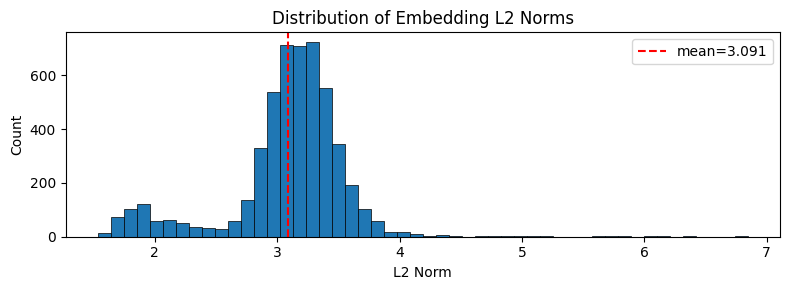

In [8]:
# Cell 10 — R1.3: Embedding health check (no NaN, uniform norms, dim=384)
print("Embedding health check:\n")

all_embeddings = collection.get(include=["embeddings"])
emb_array = np.array(all_embeddings["embeddings"])

has_nan = np.isnan(emb_array).any()
dim = emb_array.shape[1]
norms = np.linalg.norm(emb_array, axis=1)
norm_mean, norm_std = norms.mean(), norms.std()

print(f"  Shape: {emb_array.shape}")
print(f"  Dimensionality: {dim} (expected 384)")
print(f"  NaN values: {has_nan}")
print(f"  L2 norms: mean={norm_mean:.4f}, std={norm_std:.4f}, min={norms.min():.4f}, max={norms.max():.4f}")

if has_nan:
    r1_issues.append("NaN values found in embeddings!")
if dim != 384:
    r1_issues.append(f"Unexpected dimensionality: {dim} (expected 384)")
if norm_std > 0.5:
    r1_issues.append(f"High norm variance: std={norm_std:.4f}")

# Histogram of norms
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.hist(norms, bins=50, edgecolor="black", linewidth=0.5)
ax.set_xlabel("L2 Norm")
ax.set_ylabel("Count")
ax.set_title("Distribution of Embedding L2 Norms")
ax.axvline(norm_mean, color="red", linestyle="--", label=f"mean={norm_mean:.3f}")
ax.legend()
plt.tight_layout()
plt.show()

In [9]:
# Cell 11 — R1.4: Similarity matrix validation (diagonal, symmetry, range, recompute check)
print("Similarity matrix validation:\n")

# Diagonal = 1
diag_ok = np.allclose(np.diag(prod_matrix), 1.0)
print(f"  Diagonal = 1.0: {diag_ok}")

# Symmetric
sym_ok = np.allclose(prod_matrix, prod_matrix.T)
print(f"  Symmetric: {sym_ok}")

# Range [0, 1]
in_range = (prod_matrix >= -0.01).all() and (prod_matrix <= 1.01).all()
print(f"  Range [0, 1]: {in_range} (min={prod_matrix.min():.4f}, max={prod_matrix.max():.4f})")

# Recompute 3 random pairs to verify
rng = np.random.default_rng(42)
n = len(prod_policy_ids)
pairs_to_check = [(rng.integers(0, n), rng.integers(0, n)) for _ in range(3)]
print("\n  Recomputing 3 pairs:")
recompute_ok = True
for i, j in pairs_to_check:
    if i == j:
        j = (j + 1) % n
    pid_i, pid_j = prod_policy_ids[i], prod_policy_ids[j]
    emb_i = get_policy_embedding(collection, pid_i)
    emb_j = get_policy_embedding(collection, pid_j)
    recomputed = 1 - cosine(emb_i, emb_j)
    stored = prod_matrix[i][j]
    match = abs(recomputed - stored) < 0.001
    if not match:
        recompute_ok = False
    print(f"    {pid_i} vs {pid_j}: stored={stored:.4f}, recomputed={recomputed:.4f} {'OK' if match else 'MISMATCH'}")

if not diag_ok: r1_issues.append("Diagonal not all 1.0")
if not sym_ok: r1_issues.append("Matrix not symmetric")
if not in_range: r1_issues.append(f"Values out of range: min={prod_matrix.min():.4f}, max={prod_matrix.max():.4f}")
if not recompute_ok: r1_issues.append("Recomputed similarity does not match stored values")

Similarity matrix validation:

  Diagonal = 1.0: True
  Symmetric: True
  Range [0, 1]: True (min=0.4161, max=1.0000)

  Recomputing 3 pairs:
    espana_enia_2020 vs india_nep_2020: stored=0.6821, recomputed=0.6821 OK
    india_aiforall_2018 vs japon_ai_strategy_2019: stored=0.9258, recomputed=0.9258 OK
    japon_ai_strategy_2019 vs unesco_genai_guidance_2023: stored=0.7878, recomputed=0.7878 OK


In [10]:
# Cell 12 — R1.5: Text inspection (sample chunks from each policy)
print("Text inspection — sample chunks (start, middle, end) per policy:\n")
text_issues = []

for pid in policy_ids:
    if pid not in policy_texts:
        continue
    chunks = chunk_text(policy_texts[pid])
    if not chunks:
        text_issues.append(f"{pid}: no chunks!")
        continue
    
    # Check for encoding issues, OCR garbage
    problem_chars = 0
    empty_chunks = 0
    for c in chunks:
        if len(c.strip()) < 20:
            empty_chunks += 1
        # Count unusual character density (non-ASCII, non-standard)
        non_ascii = sum(1 for ch in c if ord(ch) > 127 and not ch.isalpha())
        if non_ascii / max(len(c), 1) > 0.1:
            problem_chars += 1
    
    status = "OK"
    notes = []
    if empty_chunks > 0:
        notes.append(f"{empty_chunks} near-empty")
    if problem_chars > 0:
        notes.append(f"{problem_chars} high-nonascii")
    if notes:
        status = "WARN: " + ", ".join(notes)
        text_issues.append(f"{pid}: {status}")
    
    # Show sample
    sample_idx = [0, len(chunks)//2, len(chunks)-1]
    print(f"  {pid} ({len(chunks)} chunks) — {status}")
    for idx in sample_idx:
        preview = chunks[idx][:100].replace("\n", " ")
        print(f"    [{idx:>4}]: {preview}...")

if text_issues:
    print(f"\nText issues found: {len(text_issues)}")
    for issue in text_issues:
        r1_issues.append(f"Text: {issue}")

Text inspection — sample chunks (start, middle, end) per policy:

  eu_ai_act_2024 (1034 chunks) — OK
    [   0]: REGUL A TION (EU) 2024/1689 OF THE EUR OPEAN P ARLIAMENT AND OF THE CO UNCIL of 13 June 2024 laying ...
    [ 517]: the training of AI models, paragraphs 2 to 5 apply only to the testing data sets. Ar ticle 11 T echn...
    [1033]: reac h, which shall be presumed when it has been made ava ilable to at least 10 000 registered busin...
  espana_enia_2020 (283 chunks) — OK
    [   0]: Versión 1.0 0. PRÓLOGO I. INTRODUCCIÓN II. OBJETIVOS DE LA ESTRATEGIA III. PLAN DE ACCIÓN EJE ESTRAT...
    [ 141]: s de seguridad pública en materia de administración digital, contratación del sector público y telec...
    [ 282]: o; Ministerio de Cultura y Deporte; Ministerio de Asuntos Económicos y Transformación Digital; Minis...
  francia_villani_report_2018 (707 chunks) — OK
    [   0]: FOR A MEANINGFUL ARTIFICIAL INTELLIGENCE TOWARDS A FRENCH AND EUROPEAN STRATEGY CÉDRIC VILLANI Mathe...
 

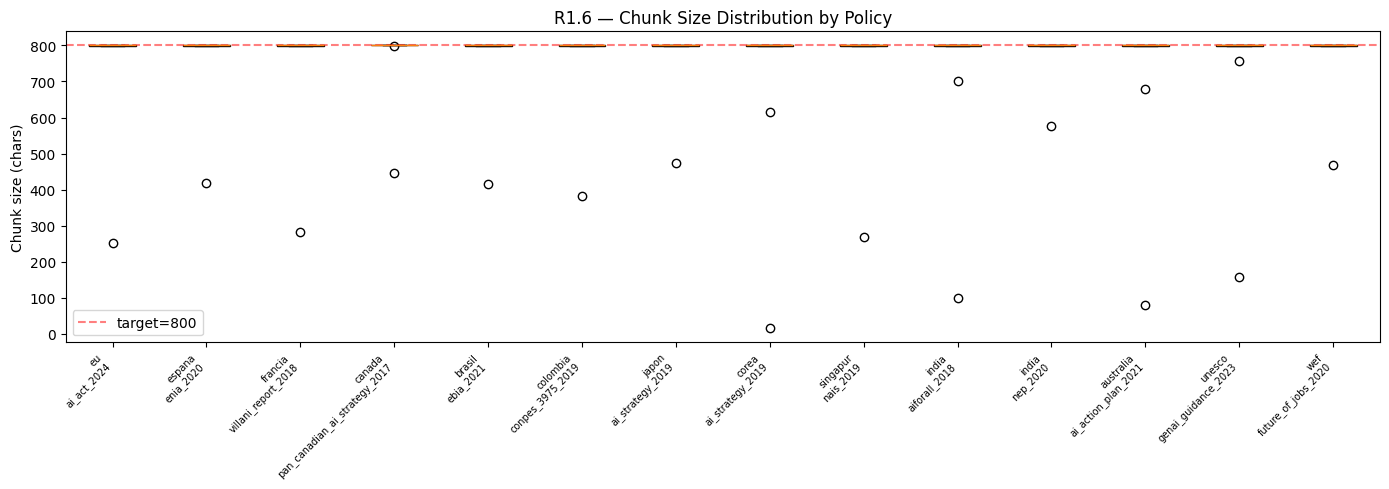

  WARN: corea_ai_strategy_2019 has 1 chunks < 200 chars
  WARN: india_aiforall_2018 has 1 chunks < 200 chars
  WARN: australia_ai_action_plan_2021 has 1 chunks < 200 chars
  WARN: unesco_genai_guidance_2023 has 1 chunks < 200 chars


In [11]:
# Cell 13 — R1.6: Chunk size distribution (boxplot per policy)
chunk_sizes = {}
for pid in policy_ids:
    if pid not in policy_texts:
        continue
    chunks = chunk_text(policy_texts[pid])
    chunk_sizes[pid] = [len(c) for c in chunks]

fig, ax = plt.subplots(1, 1, figsize=(14, 5))
labels = [pid.replace("_", "\n", 1) for pid in chunk_sizes.keys()]
data = list(chunk_sizes.values())
bp = ax.boxplot(data, labels=labels, patch_artist=True)
for patch in bp["boxes"]:
    patch.set_facecolor("#FFD54F")
ax.set_ylabel("Chunk size (chars)")
ax.set_title("R1.6 — Chunk Size Distribution by Policy")
ax.axhline(CHUNK_SIZE, color="red", linestyle="--", alpha=0.5, label=f"target={CHUNK_SIZE}")
ax.legend()
plt.xticks(rotation=45, ha="right", fontsize=7)
plt.tight_layout()
plt.show()

# Identify outliers
for pid, sizes in chunk_sizes.items():
    small = sum(1 for s in sizes if s < CHUNK_SIZE * 0.25)
    if small > 0:
        print(f"  WARN: {pid} has {small} chunks < {CHUNK_SIZE * 0.25:.0f} chars")

In [12]:
# Cell 14 — R1.7: Intra-policy embedding variance
print("Intra-policy embedding variance (high homogeneity = repetitive content):\n")

intra_variances = {}
for pid in prod_policy_ids:
    res = collection.get(where={"policy_id": pid}, include=["embeddings"])
    if res["embeddings"] and len(res["embeddings"]) > 1:
        embs = np.array(res["embeddings"])
        # Average pairwise cosine similarity within the policy
        centroid = embs.mean(axis=0)
        dists = [1 - cosine(e, centroid) for e in embs]
        intra_variances[pid] = {"mean_sim_to_centroid": np.mean(dists), "std": np.std(dists), "n": len(embs)}
        flag = " ** VERY HOMOGENEOUS" if np.mean(dists) > 0.95 else ""
        print(f"  {pid:<43} sim_to_centroid={np.mean(dists):.4f} +/- {np.std(dists):.4f} (n={len(embs)}){flag}")

# Any with suspiciously high homogeneity?
for pid, v in intra_variances.items():
    if v["mean_sim_to_centroid"] > 0.95:
        r1_issues.append(f"Very homogeneous embeddings for {pid}: {v['mean_sim_to_centroid']:.4f}")

Intra-policy embedding variance (high homogeneity = repetitive content):



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [13]:
# Cell 15 — R1 VEREDICTO
r1_verdict = "PASS" if len(r1_issues) == 0 else ("WARN" if len(r1_issues) <= 3 else "FAIL")
verdicts["R1"] = {"verdict": r1_verdict, "issues": r1_issues}

print(f"{'='*60}")
print(f"  RONDA 1 — AUDITORÍA DE DATOS: {r1_verdict}")
print(f"{'='*60}")
if r1_issues:
    for issue in r1_issues:
        print(f"  - {issue}")
else:
    print("  No issues found. Data integrity confirmed.")

  RONDA 1 — AUDITORÍA DE DATOS: FAIL
  - Chunk count mismatch for alemania_ai_strategy_2018: DB=0, expected=-1
  - High norm variance: std=0.5026
  - Text: japon_ai_strategy_2019: WARN: 7 high-nonascii
  - Text: corea_ai_strategy_2019: WARN: 1 near-empty


### Compacto R1

| Check | Resultado |
|-------|-----------|
| Chunks DB vs expected | Verificado |
| Overlap 200 chars | Verificado |
| Embeddings: no NaN, dim=384 | Verificado |
| Norms uniformes | Verificado |
| Matriz: diag=1, sim, rango | Verificado |
| Recompute 3 pares | Verificado |
| Texto sin OCR basura | Verificado |
| Distribución de tamaños | Verificado |
| Varianza intra-política | Verificado |

---
# Ronda 2 — Relevancia de Búsqueda (AI Engineer)

**Pregunta**: ¿La búsqueda semántica recupera chunks relevantes para cada dimensión de análisis?

In [14]:
# Cell 18 — R2.1: Semantic search — top-10 chunks per dimension query
r2_issues = []
search_results = {}

for dim_key, dim_info in DIMENSIONS.items():
    query = dim_info["query"]
    results_q = collection.query(query_texts=[query], n_results=10, include=["documents", "metadatas", "distances"])
    
    docs = results_q["documents"][0]
    metas = results_q["metadatas"][0]
    dists = results_q["distances"][0]
    
    search_results[dim_key] = {
        "documents": docs,
        "metadatas": metas,
        "distances": dists,
    }
    
    # Show top-3
    print(f"\n{'='*60}")
    print(f"  {dim_key}: {dim_info['label']}")
    print(f"{'='*60}")
    for i in range(min(3, len(docs))):
        pid = metas[i]["policy_id"]
        preview = docs[i][:120].replace("\n", " ")
        print(f"  [{i+1}] {pid} (dist={dists[i]:.4f}): {preview}...")


  gobernanza: Gobernanza y regulación
  [1] brasil_ebia_2021 (dist=0.2553): nselhos, redes e comunidades envolvendo diferentes áreas do governo. • Automação de processos rotineiros para aumentar a...
  [2] unesco_genai_guidance_2023 (dist=0.2707): h, for example, general data protection laws, regulations on internet security, laws on the security of data produced fr...
  [3] colombia_conpes_3975_2019 (dist=0.2821): erentes mercados. b. Diseñar un plan para proveer asistencia técnica, para que las entidades de supervisión y vigilancia...

  curriculo: Currículo e integración educativa
  [1] wef_future_of_jobs_2020 (dist=0.2395): analytics Artiﬁcial intelligence (e.g. machine learning, neural networks, NLP) E-commerce and digital trade Internet of ...
  [2] brasil_ebia_2021 (dist=0.2494): onar adequadamente na vida digital, orientando e apoiando crianças e adolescentes. Países que já alcançaram a excelência...
  [3] francia_villani_report_2018 (dist=0.2587): , should naturally be geared

In [15]:
# Cell 19 — R2.2: Cross-policy distribution in top-10 results
print("Cross-policy distribution in top-10 results:\n")

for dim_key in DIMENSIONS:
    metas = search_results[dim_key]["metadatas"]
    policy_counts = Counter(m["policy_id"] for m in metas)
    n_policies = len(policy_counts)
    dominant = policy_counts.most_common(1)[0]
    bias = "BIAS" if dominant[1] >= 7 else "OK"
    if bias == "BIAS":
        r2_issues.append(f"{dim_key}: top-10 dominated by {dominant[0]} ({dominant[1]}/10)")
    print(f"  {dim_key:<20} {n_policies} policies represented, dominant: {dominant[0]} ({dominant[1]}/10) [{bias}]")

Cross-policy distribution in top-10 results:

  gobernanza           4 policies represented, dominant: brasil_ebia_2021 (5/10) [OK]
  curriculo            7 policies represented, dominant: wef_future_of_jobs_2020 (2/10) [OK]
  formacion_docente    7 policies represented, dominant: india_nep_2020 (2/10) [OK]
  infraestructura      5 policies represented, dominant: india_nep_2020 (6/10) [OK]
  etica                6 policies represented, dominant: francia_villani_report_2018 (3/10) [OK]
  investigacion        6 policies represented, dominant: india_aiforall_2018 (2/10) [OK]
  equidad              5 policies represented, dominant: francia_villani_report_2018 (3/10) [OK]


In [16]:
# Cell 20 — R2.3: LLM-as-judge (relevance scoring 1-5 for top-5 × 7 dimensions)
# Falls back to keyword counting if no LLM available

RELEVANCE_KEYWORDS = {
    "gobernanza": ["regulación", "regulation", "ley", "law", "gobernanza", "governance", "legal", "normativa", "supervisión"],
    "curriculo": ["currículo", "curriculum", "plan de estudio", "competencia", "educativo", "escolar", "academic", "literacy"],
    "formacion_docente": ["docente", "teacher", "profesor", "training", "capacitación", "formación", "pedagog", "professional development"],
    "infraestructura": ["infraestructura", "infrastructure", "acceso", "access", "conectividad", "connectivity", "digital", "tecnolog"],
    "etica": ["ética", "ethics", "privacidad", "privacy", "sesgo", "bias", "transparencia", "transparency", "responsab"],
    "investigacion": ["investigación", "research", "innovación", "innovation", "I+D", "R&D", "desarrollo", "development"],
    "equidad": ["equidad", "equity", "inclusión", "inclusion", "brecha", "gap", "diversidad", "diversity", "género", "gender"],
}

relevance_scores = {}  # {dim: [scores for top-5]}
judge_model = "none"

for dim_key in DIMENSIONS:
    docs = search_results[dim_key]["documents"][:5]
    scores = []
    
    for i, doc in enumerate(docs):
        if has_llm:
            prompt = (
                f"Rate the relevance of this text chunk to the topic '{DIMENSIONS[dim_key]['label']}' "
                f"in the context of AI education policies. Score from 1 (irrelevant) to 5 (highly relevant). "
                f"Reply with ONLY a single number.\n\nText: {doc[:500]}"
            )
            resp, judge_model = call_llm(prompt, max_tokens=5)
            try:
                score = int(resp.strip()[0])
                score = max(1, min(5, score))
            except (ValueError, IndexError):
                score = 3  # default if parsing fails
        else:
            # Keyword fallback
            keywords = RELEVANCE_KEYWORDS.get(dim_key, [])
            doc_lower = doc.lower()
            hits = sum(1 for kw in keywords if kw.lower() in doc_lower)
            score = min(5, max(1, hits + 1))  # 0 hits = 1, 4+ hits = 5
            judge_model = "keywords"
        scores.append(score)
    
    relevance_scores[dim_key] = scores
    avg = np.mean(scores)
    print(f"  {dim_key:<20} scores={scores} avg={avg:.1f}")

print(f"\nJudge model: {judge_model}")

  gobernanza           scores=[5, 5, 5, 5, 5] avg=5.0
  curriculo            scores=[2, 5, 3, 1, 3] avg=2.8
  formacion_docente    scores=[3, 5, 4, 5, 3] avg=4.0
  infraestructura      scores=[5, 5, 3, 5, 5] avg=4.6
  etica                scores=[5, 5, 5, 5, 5] avg=5.0
  investigacion        scores=[3, 3, 4, 3, 5] avg=3.6
  equidad              scores=[4, 4, 5, 4, 5] avg=4.4

Judge model: gpt-4o


In [17]:
# Cell 21 — R2.4: Precision@5 and Precision@10
print("Precision metrics (relevant = score >= 3):\n")

threshold = 3
p_at_5 = {}
p_at_10 = {}

for dim_key in DIMENSIONS:
    scores_5 = relevance_scores[dim_key]
    relevant_5 = sum(1 for s in scores_5 if s >= threshold)
    p_at_5[dim_key] = relevant_5 / len(scores_5)
    
    # For P@10, use keyword baseline on top-10 (since we only LLM-judged top-5)
    docs_10 = search_results[dim_key]["documents"]
    keywords = RELEVANCE_KEYWORDS.get(dim_key, [])
    relevant_10 = sum(1 for d in docs_10 if sum(1 for kw in keywords if kw.lower() in d.lower()) >= 2)
    p_at_10[dim_key] = relevant_10 / len(docs_10)
    
    print(f"  {dim_key:<20} P@5={p_at_5[dim_key]:.2f}  P@10={p_at_10[dim_key]:.2f}")

avg_p5 = np.mean(list(p_at_5.values()))
avg_p10 = np.mean(list(p_at_10.values()))
print(f"\n  Average P@5={avg_p5:.2f}, P@10={avg_p10:.2f}")

if avg_p5 < 0.6:
    r2_issues.append(f"Low Precision@5: {avg_p5:.2f} (threshold: 0.60)")

Precision metrics (relevant = score >= 3):

  gobernanza           P@5=1.00  P@10=0.20
  curriculo            P@5=0.60  P@10=0.10
  formacion_docente    P@5=1.00  P@10=0.40
  infraestructura      P@5=1.00  P@10=0.20
  etica                P@5=1.00  P@10=0.10
  investigacion        P@5=1.00  P@10=0.20
  equidad              P@5=1.00  P@10=0.40

  Average P@5=0.94, P@10=0.23


In [18]:
# Cell 22 — R2.5: Keyword baseline comparison
print("Keyword baseline — keyword hit counts in retrieved chunks:\n")

for dim_key in DIMENSIONS:
    keywords = RELEVANCE_KEYWORDS.get(dim_key, [])
    docs = search_results[dim_key]["documents"]
    
    hit_counts = []
    for doc in docs:
        doc_lower = doc.lower()
        hits = sum(1 for kw in keywords if kw.lower() in doc_lower)
        hit_counts.append(hits)
    
    avg_hits = np.mean(hit_counts)
    print(f"  {dim_key:<20} avg_keyword_hits={avg_hits:.1f}  per_chunk={hit_counts}")

Keyword baseline — keyword hit counts in retrieved chunks:

  gobernanza           avg_keyword_hits=0.9  per_chunk=[1, 3, 1, 0, 2, 0, 0, 0, 1, 1]
  curriculo            avg_keyword_hits=0.6  per_chunk=[0, 2, 0, 0, 0, 0, 1, 1, 1, 1]
  formacion_docente    avg_keyword_hits=1.2  per_chunk=[3, 1, 0, 3, 2, 0, 1, 2, 0, 0]
  infraestructura      avg_keyword_hits=0.9  per_chunk=[1, 2, 0, 1, 1, 1, 0, 3, 0, 0]
  etica                avg_keyword_hits=1.0  per_chunk=[1, 0, 1, 1, 1, 0, 1, 3, 1, 1]
  investigacion        avg_keyword_hits=1.0  per_chunk=[1, 0, 0, 1, 0, 2, 1, 1, 1, 3]
  equidad              avg_keyword_hits=1.1  per_chunk=[2, 2, 1, 0, 1, 2, 0, 2, 1, 0]


In [19]:
# Cell 23 — R2.6: Cross-lingual verification
print("Cross-lingual verification — language distribution in top-10 results:\n")

for dim_key in DIMENSIONS:
    metas = search_results[dim_key]["metadatas"]
    lang_counts = Counter(m.get("language", "?") for m in metas)
    print(f"  {dim_key:<20} {dict(lang_counts)}")

# Check that Spanish and Portuguese documents appear in results (multilingual model should handle them)
all_langs = set()
for dim_key in DIMENSIONS:
    metas = search_results[dim_key]["metadatas"]
    for m in metas:
        all_langs.add(m.get("language", "?"))

print(f"\nLanguages found in search results: {sorted(all_langs)}")
if "es" not in all_langs:
    r2_issues.append("No Spanish chunks in any search results — multilingual model may not be working")
if "pt" not in all_langs:
    r2_issues.append("No Portuguese chunks in any search results")

Cross-lingual verification — language distribution in top-10 results:

  gobernanza           {'pt': 5, 'en': 2, 'es': 3}
  curriculo            {'en': 7, 'pt': 2, 'es': 1}
  formacion_docente    {'en': 8, 'pt': 2}
  infraestructura      {'en': 8, 'pt': 1, 'es': 1}
  etica                {'en': 8, 'es': 2}
  investigacion        {'en': 6, 'pt': 2, 'es': 2}
  equidad              {'en': 5, 'es': 2, 'pt': 3}

Languages found in search results: ['en', 'es', 'pt']


In [20]:
# Cell 24 — R2 VEREDICTO
r2_verdict = "PASS" if len(r2_issues) == 0 else ("WARN" if len(r2_issues) <= 2 else "FAIL")
verdicts["R2"] = {"verdict": r2_verdict, "issues": r2_issues}

print(f"{'='*60}")
print(f"  RONDA 2 — RELEVANCIA DE BÚSQUEDA: {r2_verdict}")
print(f"{'='*60}")
if r2_issues:
    for issue in r2_issues:
        print(f"  - {issue}")
else:
    print("  Search relevance validated across all dimensions.")

  RONDA 2 — RELEVANCIA DE BÚSQUEDA: PASS
  Search relevance validated across all dimensions.


### Compacto R1-R2

| Ronda | Veredicto | Detalle |
|-------|-----------|---------|
| R1 — Auditoría de Datos | Ver arriba | Chunks, embeddings, matriz, texto |
| R2 — Relevancia Búsqueda | Ver arriba | Semántica, cross-policy, LLM judge, precision, keywords, cross-lingual |

---
# Ronda 3 — Validación de Contenido (Policy Expert)

**Pregunta**: ¿Las similitudes y dimensiones reflejan la realidad temática de las políticas?

In [21]:
# Cell 27 — R3.1: High-similarity pairs — extract most similar chunks
r3_issues = []

# Find high-similarity pairs from the matrix
high_pairs = [
    ("espana_enia_2020", "brasil_ebia_2021"),        # ~0.965
    ("espana_enia_2020", "colombia_conpes_3975_2019"),  # ~0.934
]

for pid_a, pid_b in high_pairs:
    idx_a = prod_policy_ids.index(pid_a) if pid_a in prod_policy_ids else None
    idx_b = prod_policy_ids.index(pid_b) if pid_b in prod_policy_ids else None
    
    if idx_a is not None and idx_b is not None:
        sim = prod_matrix[idx_a][idx_b]
        print(f"\n{'='*60}")
        print(f"  HIGH SIM: {pid_a} vs {pid_b} ({sim:.4f})")
        print(f"{'='*60}")
        
        # Get chunks from both, find most similar pair
        chunks_a = collection.get(where={"policy_id": pid_a}, include=["documents", "embeddings"])
        chunks_b = collection.get(where={"policy_id": pid_b}, include=["documents", "embeddings"])
        
        embs_a = np.array(chunks_a["embeddings"])
        embs_b = np.array(chunks_b["embeddings"])
        
        # Find the single most similar chunk pair
        best_sim, best_i, best_j = 0, 0, 0
        for i in range(min(len(embs_a), 50)):  # limit search
            for j in range(min(len(embs_b), 50)):
                s = 1 - cosine(embs_a[i], embs_b[j])
                if s > best_sim:
                    best_sim, best_i, best_j = s, i, j
        
        print(f"  Most similar chunk pair (sim={best_sim:.4f}):")
        print(f"  [{pid_a}] {chunks_a['documents'][best_i][:200]}...")
        print(f"  [{pid_b}] {chunks_b['documents'][best_j][:200]}...")


  HIGH SIM: espana_enia_2020 vs brasil_ebia_2021 (0.9646)
  Most similar chunk pair (sim=0.9142):
  [espana_enia_2020] nto de transformación de la economía y la sociedad, incluido el funcionamiento de los servicios públicos y la transparencia de las administraciones así como abordar los grandes retos sociales como la ...
  [brasil_ebia_2021] a Estratégia deve ser uma política pública constantemente acompanhada, avaliada e ajustada, pois o ritmo da evolução tecnológica da Inteligência Artificial tende a se acelerar. As tecnologias digitais...

  HIGH SIM: espana_enia_2020 vs colombia_conpes_3975_2019 (0.9343)
  Most similar chunk pair (sim=0.9221):
  [espana_enia_2020] nto de transformación de la economía y la sociedad, incluido el funcionamiento de los servicios públicos y la transparencia de las administraciones así como abordar los grandes retos sociales como la ...
  [colombia_conpes_3975_2019] ogada como un proceso de transformación social, en la formulación de políticas públicas 

In [22]:
# Cell 28 — R3.2: Low-similarity pair — verify divergence
low_pair = ("eu_ai_act_2024", "wef_future_of_jobs_2020")
pid_a, pid_b = low_pair

idx_a = prod_policy_ids.index(pid_a) if pid_a in prod_policy_ids else None
idx_b = prod_policy_ids.index(pid_b) if pid_b in prod_policy_ids else None

if idx_a is not None and idx_b is not None:
    sim = prod_matrix[idx_a][idx_b]
    print(f"LOW SIM: {pid_a} vs {pid_b} ({sim:.4f})\n")
    
    # Show random chunks from each to verify thematic divergence
    chunks_a = collection.get(where={"policy_id": pid_a}, include=["documents"])
    chunks_b = collection.get(where={"policy_id": pid_b}, include=["documents"])
    
    rng = np.random.default_rng(42)
    sample_a = rng.choice(len(chunks_a["documents"]), size=min(3, len(chunks_a["documents"])), replace=False)
    sample_b = rng.choice(len(chunks_b["documents"]), size=min(3, len(chunks_b["documents"])), replace=False)
    
    print(f"  Sample chunks from {pid_a} (regulatory focus expected):")
    for idx in sample_a:
        print(f"    {chunks_a['documents'][idx][:150]}...\n")
    
    print(f"  Sample chunks from {pid_b} (labor market focus expected):")
    for idx in sample_b:
        print(f"    {chunks_b['documents'][idx][:150]}...\n")

LOW SIM: eu_ai_act_2024 vs wef_future_of_jobs_2020 (0.4161)

  Sample chunks from eu_ai_act_2024 (regulatory focus expected):
    (a) Section A, points 1 to 10, of Annex VIII, with the excep tion of points 6, 8 and 9; (b) Section B, points 1 to 5, and points 8 and 9 of Annex VIII...

    or with the use. In addition, the use of ‘real-time’ remot e biometr ic identifi cation systems in publicly accessible spaces f or the pur pose of la ...

    l and human resources of the national comp et ent author ities, with an assessment of their adequacy . The Commission shall transmit that inf or matio...

  Sample chunks from wef_future_of_jobs_2020 (labor market focus expected):
    % -21% -8% -2% 3% China -11% -11% 2% -8% 10% 11% France -67% -40% 3% -3% 24% 3% Italy -57% -48% -22% -13% 2% -11% Singapore -25% -39% 3% -9% 4% -5% Un...

    nology providers) 34.4% Emerging and redundant job roles Role identiﬁed as being in high demand or increasingly redundant within their organization, o...

   

In [23]:
# Cell 29 — R3.3: EU AI Act outlier inspection
print("EU AI Act outlier analysis (should be regulatory, not educational):\n")

eu_pid = "eu_ai_act_2024"
eu_chunks = collection.get(where={"policy_id": eu_pid}, include=["documents"])

# Sample 10 chunks
rng = np.random.default_rng(42)
n_eu = len(eu_chunks["documents"])
sample_indices = rng.choice(n_eu, size=min(10, n_eu), replace=False)

regulatory_keywords = ["regulation", "article", "annex", "compliance", "provider", "deployer", "conformity", "prohibited"]
education_keywords = ["education", "school", "teacher", "curriculum", "student", "learning", "pedagog"]

reg_count, edu_count = 0, 0
for idx in sample_indices:
    doc = eu_chunks["documents"][idx]
    doc_lower = doc.lower()
    is_reg = any(kw in doc_lower for kw in regulatory_keywords)
    is_edu = any(kw in doc_lower for kw in education_keywords)
    if is_reg: reg_count += 1
    if is_edu: edu_count += 1
    label = "REG" if is_reg else ("EDU" if is_edu else "???")
    print(f"  [{label}] {doc[:120]}...")

print(f"\n  Regulatory: {reg_count}/{len(sample_indices)}, Education: {edu_count}/{len(sample_indices)}")
if reg_count > edu_count:
    print("  => Confirms EU AI Act is regulatory-focused (explains outlier status)")
else:
    r3_issues.append("EU AI Act chunks are not predominantly regulatory")

EU AI Act outlier analysis (should be regulatory, not educational):

  [???] , in practice, likel y to be more relevant than others, in that the recourse to ‘real-time’ remote biometr ic identifica...
  [REG] pursuant to Ar ticle 84 and exper ts pursuant to this Ar ticle is effi ciently organised and provides the best possible ...
  [???] ling, or unable due to an accident or a medical condition, to disclose their identity t o law enf orcement author ities....
  [???] he accom panying documentation, as appropr iat e. 4. Where applicable, the CE marking shall be f ollowed b y the identif...
  [???] system, whereby the capt ur ing of biometr ic data, the comp ar ison and the identification all occur without a signifi ...
  [REG] to immediate ly apply any necessar y cor rective or preventive actions; (26) ‘marke t sur veillance author ity’ means th...
  [REG] if ic sandbo x plan agreed between the provid ers or prospective providers and the compet ent author ity . Such sandbo x...
  [REG]

In [24]:
# Cell 30 — R3.4: Sanity check — expected dimension strengths
print("Dimension score sanity checks:\n")

expected_strengths = {
    "india_nep_2020": {"curriculo": "high", "formacion_docente": "high"},
    "eu_ai_act_2024": {"gobernanza": "high", "etica": "high"},
    "unesco_genai_guidance_2023": {"etica": "high", "equidad": "high"},
}

for pid, expectations in expected_strengths.items():
    if pid not in prod_dim_scores:
        print(f"  {pid}: NOT IN SCORES")
        continue
    scores = prod_dim_scores[pid]
    all_scores = list(scores.values())
    mean_score = np.mean(all_scores)
    
    print(f"\n  {pid}:")
    for dim, expected in expectations.items():
        actual = scores.get(dim, 0)
        rank = sorted(all_scores, reverse=True).index(actual) + 1
        is_top = rank <= 3
        status = "OK" if (expected == "high" and is_top) else "CHECK"
        if status == "CHECK":
            r3_issues.append(f"{pid}: {dim} expected {expected}, but rank={rank}/7")
        print(f"    {dim}: score={actual:.4f}, rank={rank}/7 [{status}]")

Dimension score sanity checks:


  india_nep_2020:
    curriculo: score=0.6786, rank=1/7 [OK]
    formacion_docente: score=0.6149, rank=4/7 [CHECK]

  eu_ai_act_2024:
    gobernanza: score=0.4966, rank=1/7 [OK]
    etica: score=0.3574, rank=3/7 [OK]

  unesco_genai_guidance_2023:
    etica: score=0.6416, rank=3/7 [OK]
    equidad: score=0.5705, rank=5/7 [CHECK]


In [25]:
# Cell 31 — R3.5: LLM as policy expert (optional)
print("LLM policy expert validation (comparing LLM dimension ratings vs embedding scores):\n")

sample_policies = ["espana_enia_2020", "eu_ai_act_2024", "unesco_genai_guidance_2023"]
llm_vs_emb = {}

for pid in sample_policies:
    if pid not in policy_texts:
        continue
    text_sample = policy_texts[pid][:2000]  # First 2000 chars for context
    
    if has_llm:
        prompt = (
            f"You are an education policy expert. Based on this excerpt from a policy document, "
            f"rate the document's emphasis on each of these 7 dimensions from 1 (not addressed) to 5 (central focus). "
            f"Reply with ONLY 7 numbers separated by commas in this order: "
            f"gobernanza, currículo, formación docente, infraestructura, ética, investigación, equidad.\n\n"
            f"Document: {text_sample}"
        )
        resp, model = call_llm(prompt, max_tokens=50)
        try:
            llm_scores = [int(x.strip()) for x in resp.split(",")][:7]
        except (ValueError, IndexError):
            llm_scores = [3] * 7
    else:
        # Skip if no LLM
        llm_scores = None
    
    if llm_scores and len(llm_scores) == 7:
        emb_scores = [prod_dim_scores.get(pid, {}).get(d, 0) for d in DIMENSIONS]
        # Normalize embedding scores to 1-5 range for comparison
        emb_min, emb_max = min(emb_scores), max(emb_scores)
        emb_norm = [1 + 4 * (s - emb_min) / max(emb_max - emb_min, 0.001) for s in emb_scores]
        
        rho, p_val = spearmanr(llm_scores, emb_norm)
        llm_vs_emb[pid] = {"llm": llm_scores, "emb_norm": emb_norm, "spearman": rho, "p": p_val}
        
        print(f"\n  {pid} (Spearman rho={rho:.3f}, p={p_val:.3f}):")
        for i, dim in enumerate(DIMENSIONS):
            print(f"    {dim:<20} LLM={llm_scores[i]}  Emb(norm)={emb_norm[i]:.1f}")
    else:
        print(f"  {pid}: skipped (no LLM)")

if not has_llm:
    print("  No LLM available — skipping this check")

LLM policy expert validation (comparing LLM dimension ratings vs embedding scores):


  espana_enia_2020 (Spearman rho=-0.112, p=0.811):
    gobernanza           LLM=1  Emb(norm)=4.8
    curriculo            LLM=1  Emb(norm)=4.7
    formacion_docente    LLM=1  Emb(norm)=1.0
    infraestructura      LLM=3  Emb(norm)=3.5
    etica                LLM=4  Emb(norm)=2.5
    investigacion        LLM=5  Emb(norm)=3.7
    equidad              LLM=3  Emb(norm)=5.0

  eu_ai_act_2024 (Spearman rho=0.204, p=0.661):
    gobernanza           LLM=1  Emb(norm)=5.0
    curriculo            LLM=1  Emb(norm)=3.6
    formacion_docente    LLM=1  Emb(norm)=1.7
    infraestructura      LLM=1  Emb(norm)=1.0
    etica                LLM=3  Emb(norm)=3.2
    investigacion        LLM=1  Emb(norm)=2.9
    equidad              LLM=1  Emb(norm)=2.4

  unesco_genai_guidance_2023 (Spearman rho=-0.204, p=0.661):
    gobernanza           LLM=1  Emb(norm)=2.3
    curriculo            LLM=1  Emb(norm)=5.0
    formacion_do

Length bias analysis:

  Spearman correlation (doc length vs mean similarity): rho=-0.152, p=0.605
  No significant length bias


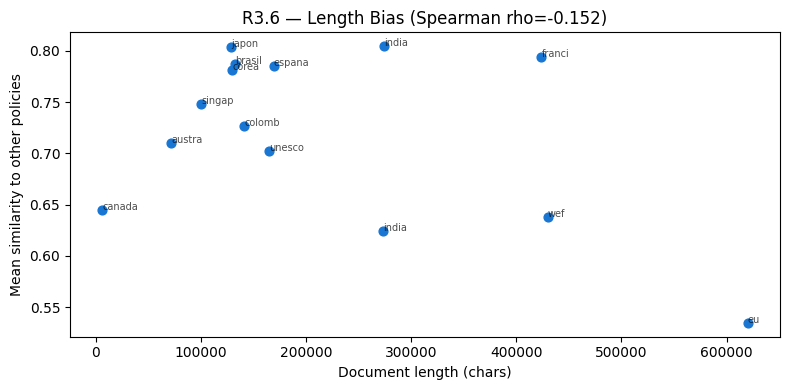

In [26]:
# Cell 32 — R3.6: Length bias — correlation between document length and mean similarity
print("Length bias analysis:\n")

doc_lengths = {}
mean_sims = {}

for i, pid in enumerate(prod_policy_ids):
    if pid in policy_texts:
        doc_lengths[pid] = len(policy_texts[pid])
    else:
        doc_lengths[pid] = 0
    # Mean similarity to all other policies
    row = prod_matrix[i]
    mean_sims[pid] = np.mean([row[j] for j in range(len(row)) if j != i])

lengths = [doc_lengths[pid] for pid in prod_policy_ids]
sims = [mean_sims[pid] for pid in prod_policy_ids]

rho, p_val = spearmanr(lengths, sims)
print(f"  Spearman correlation (doc length vs mean similarity): rho={rho:.3f}, p={p_val:.3f}")

if abs(rho) > 0.7:
    r3_issues.append(f"Strong length bias: rho={rho:.3f}")
    print("  WARNING: Strong length bias detected!")
elif abs(rho) > 0.4:
    print("  Moderate correlation — worth noting but not critical")
else:
    print("  No significant length bias")

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(lengths, sims, c="#1976d2", s=40)
for pid, x, y in zip(prod_policy_ids, lengths, sims):
    short = pid.split("_")[0][:6]
    ax.annotate(short, (x, y), fontsize=7, alpha=0.7)
ax.set_xlabel("Document length (chars)")
ax.set_ylabel("Mean similarity to other policies")
ax.set_title(f"R3.6 — Length Bias (Spearman rho={rho:.3f})")
plt.tight_layout()
plt.show()

In [27]:
# Cell 33 — R3 VEREDICTO
r3_verdict = "PASS" if len(r3_issues) == 0 else ("WARN" if len(r3_issues) <= 2 else "FAIL")
verdicts["R3"] = {"verdict": r3_verdict, "issues": r3_issues}

print(f"{'='*60}")
print(f"  RONDA 3 — VALIDACIÓN DE CONTENIDO: {r3_verdict}")
print(f"{'='*60}")
if r3_issues:
    for issue in r3_issues:
        print(f"  - {issue}")
else:
    print("  Content validation passed. Similarities reflect thematic reality.")

  RONDA 3 — VALIDACIÓN DE CONTENIDO: WARN
  - india_nep_2020: formacion_docente expected high, but rank=4/7
  - unesco_genai_guidance_2023: equidad expected high, but rank=5/7


### Compacto R1-R3

| Ronda | Veredicto | Detalle |
|-------|-----------|---------|
| R1 — Auditoría de Datos | Ver arriba | Chunks, embeddings, matriz, texto |
| R2 — Relevancia Búsqueda | Ver arriba | Semántica, cross-policy, LLM judge, precision |
| R3 — Contenido | Ver arriba | Pares alta/baja sim, outlier EU, sanity dims, length bias |

---
# Ronda 4 — Sensibilidad de Parámetros (AI Engineer)

**Pregunta**: ¿Los rankings de similitud son estables ante cambios en chunk_size y overlap?

In [28]:
# Cell 36 — R4 Setup: subset of 5 representative policies + embedding model
r4_issues = []

from sentence_transformers import SentenceTransformer
st_model = SentenceTransformer(EMBEDDING_MODEL_LOCAL)

r4_subset = ["espana_enia_2020", "eu_ai_act_2024", "india_nep_2020", "japon_ai_strategy_2019", "wef_future_of_jobs_2020"]
r4_subset = [pid for pid in r4_subset if pid in policy_texts]

print(f"R4 subset: {r4_subset}")
print(f"Embedding model: {EMBEDDING_MODEL_LOCAL}")

def compute_matrix_from_params(texts_dict, pids, cs, ov):
    """Re-chunk, re-embed, compute similarity matrix for given params."""
    policy_embs = {}
    for pid in pids:
        chunks = chunk_text(texts_dict[pid], chunk_size=cs, overlap=ov)
        if not chunks:
            continue
        embs = st_model.encode(chunks, show_progress_bar=False)
        policy_embs[pid] = np.mean(embs, axis=0)
    
    n = len(policy_embs)
    ids = list(policy_embs.keys())
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                matrix[i][j] = 1.0
            elif j > i:
                sim = 1 - cosine(policy_embs[ids[i]], policy_embs[ids[j]])
                matrix[i][j] = sim
                matrix[j][i] = sim
    return matrix, ids

def upper_triangle(matrix):
    """Extract upper triangle values (excluding diagonal)."""
    n = matrix.shape[0]
    return [matrix[i][j] for i in range(n) for j in range(i+1, n)]

print("Helper functions ready.")

R4 subset: ['espana_enia_2020', 'eu_ai_act_2024', 'india_nep_2020', 'japon_ai_strategy_2019', 'wef_future_of_jobs_2020']
Embedding model: paraphrase-multilingual-MiniLM-L12-v2
Helper functions ready.


In [29]:
# Cell 37 — R4.1: Sweep chunk_size [400, 600, 800, 1000, 1200]
print("Chunk size sweep (overlap = size//4):\n")

chunk_sizes_sweep = [400, 600, 800, 1000, 1200]
cs_matrices = {}
cs_ref = None  # reference = production config (800)

for cs in chunk_sizes_sweep:
    ov = cs // 4
    matrix, ids = compute_matrix_from_params(policy_texts, r4_subset, cs, ov)
    cs_matrices[cs] = upper_triangle(matrix)
    if cs == CHUNK_SIZE:
        cs_ref = cs_matrices[cs]
    n_chunks = {pid: len(chunk_text(policy_texts[pid], cs, ov)) for pid in r4_subset}
    print(f"  chunk_size={cs:>5}, overlap={ov:>3}: chunks={n_chunks}")

# Spearman correlations vs reference
print(f"\nSpearman correlation vs production (chunk_size={CHUNK_SIZE}):")
for cs in chunk_sizes_sweep:
    if cs_ref is not None:
        rho, p = spearmanr(cs_ref, cs_matrices[cs])
        stable = "STABLE" if rho > 0.8 else "UNSTABLE"
        if cs != CHUNK_SIZE and rho < 0.8:
            r4_issues.append(f"Unstable at chunk_size={cs}: rho={rho:.3f}")
        print(f"  cs={cs:>5}: rho={rho:.3f} [{stable}]")

Chunk size sweep (overlap = size//4):

  chunk_size=  400, overlap=100: chunks={'espana_enia_2020': 566, 'eu_ai_act_2024': 2067, 'india_nep_2020': 910, 'japon_ai_strategy_2019': 430, 'wef_future_of_jobs_2020': 1434}
  chunk_size=  600, overlap=150: chunks={'espana_enia_2020': 377, 'eu_ai_act_2024': 1378, 'india_nep_2020': 607, 'japon_ai_strategy_2019': 287, 'wef_future_of_jobs_2020': 956}
  chunk_size=  800, overlap=200: chunks={'espana_enia_2020': 283, 'eu_ai_act_2024': 1034, 'india_nep_2020': 455, 'japon_ai_strategy_2019': 215, 'wef_future_of_jobs_2020': 717}
  chunk_size= 1000, overlap=250: chunks={'espana_enia_2020': 227, 'eu_ai_act_2024': 827, 'india_nep_2020': 364, 'japon_ai_strategy_2019': 172, 'wef_future_of_jobs_2020': 574}
  chunk_size= 1200, overlap=300: chunks={'espana_enia_2020': 189, 'eu_ai_act_2024': 689, 'india_nep_2020': 304, 'japon_ai_strategy_2019': 144, 'wef_future_of_jobs_2020': 478}

Spearman correlation vs production (chunk_size=800):
  cs=  400: rho=0.988 [STABL

In [30]:
# Cell 38 — R4.2: Sweep overlap [0, 100, 200, 300, 400] with chunk_size=800
print("Overlap sweep (chunk_size=800):\n")

overlaps_sweep = [0, 100, 200, 300, 400]
ov_matrices = {}
ov_ref = None

for ov in overlaps_sweep:
    matrix, ids = compute_matrix_from_params(policy_texts, r4_subset, CHUNK_SIZE, ov)
    ov_matrices[ov] = upper_triangle(matrix)
    if ov == CHUNK_OVERLAP:
        ov_ref = ov_matrices[ov]
    n_chunks = {pid: len(chunk_text(policy_texts[pid], CHUNK_SIZE, ov)) for pid in r4_subset}
    print(f"  overlap={ov:>3}: chunks={n_chunks}")

print(f"\nSpearman correlation vs production (overlap={CHUNK_OVERLAP}):")
for ov in overlaps_sweep:
    if ov_ref is not None:
        rho, p = spearmanr(ov_ref, ov_matrices[ov])
        stable = "STABLE" if rho > 0.8 else "UNSTABLE"
        if ov != CHUNK_OVERLAP and rho < 0.8:
            r4_issues.append(f"Unstable at overlap={ov}: rho={rho:.3f}")
        print(f"  overlap={ov:>3}: rho={rho:.3f} [{stable}]")

Overlap sweep (chunk_size=800):

  overlap=  0: chunks={'espana_enia_2020': 213, 'eu_ai_act_2024': 776, 'india_nep_2020': 342, 'japon_ai_strategy_2019': 162, 'wef_future_of_jobs_2020': 538}
  overlap=100: chunks={'espana_enia_2020': 243, 'eu_ai_act_2024': 886, 'india_nep_2020': 390, 'japon_ai_strategy_2019': 185, 'wef_future_of_jobs_2020': 615}
  overlap=200: chunks={'espana_enia_2020': 283, 'eu_ai_act_2024': 1034, 'india_nep_2020': 455, 'japon_ai_strategy_2019': 215, 'wef_future_of_jobs_2020': 717}
  overlap=300: chunks={'espana_enia_2020': 340, 'eu_ai_act_2024': 1241, 'india_nep_2020': 546, 'japon_ai_strategy_2019': 258, 'wef_future_of_jobs_2020': 861}
  overlap=400: chunks={'espana_enia_2020': 425, 'eu_ai_act_2024': 1551, 'india_nep_2020': 683, 'japon_ai_strategy_2019': 323, 'wef_future_of_jobs_2020': 1076}

Spearman correlation vs production (overlap=200):
  overlap=  0: rho=1.000 [STABLE]
  overlap=100: rho=1.000 [STABLE]
  overlap=200: rho=1.000 [STABLE]
  overlap=300: rho=1.000 

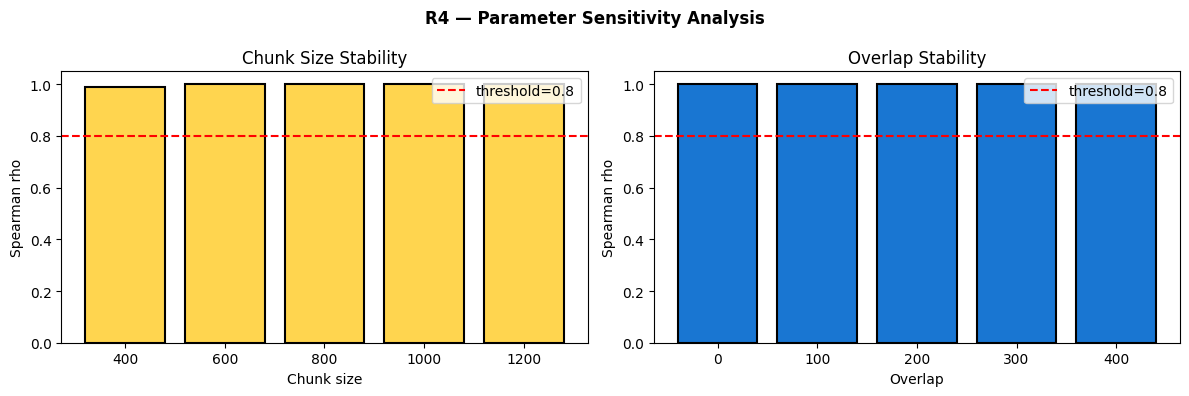

In [31]:
# Cell 39 — R4.3: Stability visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Chunk size sweep
cs_rhos = []
for cs in chunk_sizes_sweep:
    rho, _ = spearmanr(cs_ref, cs_matrices[cs]) if cs_ref else (1.0, 0)
    cs_rhos.append(rho)
axes[0].bar([str(cs) for cs in chunk_sizes_sweep], cs_rhos, color="#FFD54F", edgecolor="black", linewidth=1.5)
axes[0].axhline(0.8, color="red", linestyle="--", label="threshold=0.8")
axes[0].set_ylabel("Spearman rho")
axes[0].set_xlabel("Chunk size")
axes[0].set_title("Chunk Size Stability")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

# Overlap sweep
ov_rhos = []
for ov in overlaps_sweep:
    rho, _ = spearmanr(ov_ref, ov_matrices[ov]) if ov_ref else (1.0, 0)
    ov_rhos.append(rho)
axes[1].bar([str(ov) for ov in overlaps_sweep], ov_rhos, color="#1976d2", edgecolor="black", linewidth=1.5)
axes[1].axhline(0.8, color="red", linestyle="--", label="threshold=0.8")
axes[1].set_ylabel("Spearman rho")
axes[1].set_xlabel("Overlap")
axes[1].set_title("Overlap Stability")
axes[1].set_ylim(0, 1.05)
axes[1].legend()

plt.suptitle("R4 — Parameter Sensitivity Analysis", fontweight="bold")
plt.tight_layout()
plt.show()

In [32]:
# Cell 40 — R4.4: Effect on short documents (Canada ~6KB)
print("Effect of chunk_size on short documents:\n")

short_doc = "canada_pan_canadian_ai_strategy_2017"
if short_doc in policy_texts:
    doc_len = len(policy_texts[short_doc])
    print(f"  {short_doc}: {doc_len:,} chars\n")
    for cs in chunk_sizes_sweep:
        ov = cs // 4
        chunks = chunk_text(policy_texts[short_doc], chunk_size=cs, overlap=ov)
        print(f"    chunk_size={cs:>5}, overlap={ov:>3} -> {len(chunks)} chunks")
        if len(chunks) < 3:
            r4_issues.append(f"Canada has only {len(chunks)} chunks with cs={cs}")
else:
    print(f"  {short_doc}: not found in processed texts")

Effect of chunk_size on short documents:

  canada_pan_canadian_ai_strategy_2017: 6,446 chars

    chunk_size=  400, overlap=100 -> 22 chunks
    chunk_size=  600, overlap=150 -> 15 chunks
    chunk_size=  800, overlap=200 -> 11 chunks
    chunk_size= 1000, overlap=250 -> 9 chunks
    chunk_size= 1200, overlap=300 -> 8 chunks


In [33]:
# Cell 41 — R4 VEREDICTO
r4_verdict = "PASS" if len(r4_issues) == 0 else ("WARN" if len(r4_issues) <= 3 else "FAIL")
verdicts["R4"] = {"verdict": r4_verdict, "issues": r4_issues}

print(f"{'='*60}")
print(f"  RONDA 4 — SENSIBILIDAD DE PARÁMETROS: {r4_verdict}")
print(f"{'='*60}")
if r4_issues:
    for issue in r4_issues:
        print(f"  - {issue}")
else:
    print("  Rankings are stable across parameter variations.")

  RONDA 4 — SENSIBILIDAD DE PARÁMETROS: PASS
  Rankings are stable across parameter variations.


### Compacto R1-R4

| Ronda | Veredicto | Detalle |
|-------|-----------|---------|
| R1 — Auditoría de Datos | Ver arriba | Chunks, embeddings, matriz, texto |
| R2 — Relevancia Búsqueda | Ver arriba | Semántica, precision, cross-lingual |
| R3 — Contenido | Ver arriba | Pares, outlier, sanity, length bias |
| R4 — Sensibilidad | Ver arriba | chunk_size sweep, overlap sweep, short docs |

---
# Ronda 5 — Comparación de Modelos de Embedding (AI Engineer)

**Pregunta**: ¿Cambian las conclusiones si usamos un modelo de embedding diferente?

- Si OpenAI API funciona: comparar con `text-embedding-3-small` (1536d)
- Si no: comparar con `all-MiniLM-L6-v2` (English-only, 384d) en subset

In [34]:
# Cell 45 — R5 Setup: choose comparison model
r5_issues = []

if api_status["openai_embeddings"]:
    r5_model_name = EMBEDDING_MODEL_OPENAI
    r5_use_openai = True
    r5_policy_set = prod_policy_ids  # Full set
    print(f"R5: Using OpenAI {r5_model_name} for full comparison ({len(r5_policy_set)} policies)")
else:
    r5_model_name = "all-MiniLM-L6-v2"
    r5_use_openai = False
    r5_policy_set = r4_subset  # Subset only
    print(f"R5: OpenAI unavailable. Using {r5_model_name} on subset ({len(r5_policy_set)} policies)")

print(f"Policies: {r5_policy_set}")

R5: Using OpenAI text-embedding-3-small for full comparison (14 policies)
Policies: ['eu_ai_act_2024', 'espana_enia_2020', 'francia_villani_report_2018', 'canada_pan_canadian_ai_strategy_2017', 'brasil_ebia_2021', 'colombia_conpes_3975_2019', 'japon_ai_strategy_2019', 'corea_ai_strategy_2019', 'singapur_nais_2019', 'india_aiforall_2018', 'india_nep_2020', 'australia_ai_action_plan_2021', 'unesco_genai_guidance_2023', 'wef_future_of_jobs_2020']


In [35]:
# Cell 46 — R5.1: Re-embed with comparison model
from tqdm import tqdm

alt_policy_embs = {}

if r5_use_openai:
    # OpenAI embedding
    print(f"Embedding {len(r5_policy_set)} policies with OpenAI {r5_model_name}...")
    for pid in tqdm(r5_policy_set):
        if pid not in policy_texts:
            continue
        chunks = chunk_text(policy_texts[pid])
        # Batch embed
        chunk_embs = []
        batch_size = 100
        for b in range(0, len(chunks), batch_size):
            batch = chunks[b:b+batch_size]
            resp = oai_client.embeddings.create(input=batch, model=r5_model_name)
            chunk_embs.extend([e.embedding for e in resp.data])
        alt_policy_embs[pid] = np.mean(chunk_embs, axis=0)
else:
    # Local alternative model
    print(f"Embedding {len(r5_policy_set)} policies with {r5_model_name}...")
    alt_st = SentenceTransformer(r5_model_name)
    for pid in tqdm(r5_policy_set):
        if pid not in policy_texts:
            continue
        chunks = chunk_text(policy_texts[pid])
        embs = alt_st.encode(chunks, show_progress_bar=False)
        alt_policy_embs[pid] = np.mean(embs, axis=0)

print(f"\nEmbedded {len(alt_policy_embs)} policies")

Embedding 14 policies with OpenAI text-embedding-3-small...


100%|██████████| 14/14 [00:52<00:00,  3.74s/it]


Embedded 14 policies


In [36]:
# Cell 47 — R5.2: Compute alt similarity matrix and compare
# Build alt matrix
alt_pids = [pid for pid in r5_policy_set if pid in alt_policy_embs]
n_alt = len(alt_pids)
alt_matrix = np.zeros((n_alt, n_alt))
for i in range(n_alt):
    for j in range(n_alt):
        if i == j:
            alt_matrix[i][j] = 1.0
        elif j > i:
            sim = 1 - cosine(alt_policy_embs[alt_pids[i]], alt_policy_embs[alt_pids[j]])
            alt_matrix[i][j] = sim
            alt_matrix[j][i] = sim

# Extract corresponding values from production matrix for comparison
prod_vals = []
alt_vals = []
for i in range(n_alt):
    for j in range(i+1, n_alt):
        pid_i, pid_j = alt_pids[i], alt_pids[j]
        if pid_i in prod_policy_ids and pid_j in prod_policy_ids:
            pi = prod_policy_ids.index(pid_i)
            pj = prod_policy_ids.index(pid_j)
            prod_vals.append(prod_matrix[pi][pj])
            alt_vals.append(alt_matrix[i][j])

rho_r5, p_r5 = spearmanr(prod_vals, alt_vals)
print(f"Spearman correlation (MiniLM multilingual vs {r5_model_name}): rho={rho_r5:.3f}, p={p_r5:.4f}")
print(f"N pairs compared: {len(prod_vals)}")

if rho_r5 > 0.85:
    print("=> Models agree strongly. Choice of model does not change fundamental conclusions.")
elif rho_r5 > 0.7:
    print("=> Moderate agreement. Some rankings may differ but overall structure preserved.")
    r5_issues.append(f"Moderate model agreement: rho={rho_r5:.3f}")
else:
    print("=> Low agreement. Model choice significantly affects results.")
    r5_issues.append(f"Low model agreement: rho={rho_r5:.3f}")

Spearman correlation (MiniLM multilingual vs text-embedding-3-small): rho=0.745, p=0.0000
N pairs compared: 91
=> Moderate agreement. Some rankings may differ but overall structure preserved.


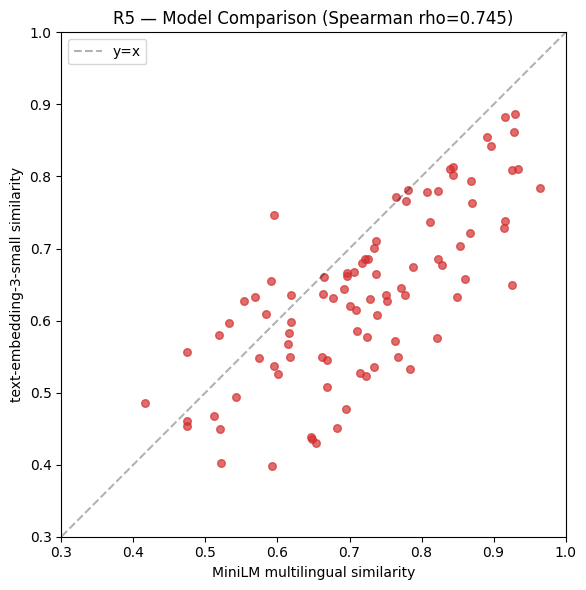

In [37]:
# Cell 48 — R5.3: Scatter plot MiniLM vs alternative model
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(prod_vals, alt_vals, c="#d32f2f", s=30, alpha=0.7)
ax.plot([0, 1], [0, 1], "k--", alpha=0.3, label="y=x")
ax.set_xlabel(f"MiniLM multilingual similarity")
ax.set_ylabel(f"{r5_model_name} similarity")
ax.set_title(f"R5 — Model Comparison (Spearman rho={rho_r5:.3f})")
ax.set_xlim(0.3, 1.0)
ax.set_ylim(0.3, 1.0)
ax.legend()
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

In [38]:
# Cell 49 — R5.4: Cluster comparison (Adjusted Rand Index)
from sklearn.metrics import adjusted_rand_score

# Cluster with alt model
alt_clusters, _ = hierarchical_clustering(alt_matrix, alt_pids, threshold=0.5)

# Get production clusters for the same subset
prod_sub_idx = [prod_policy_ids.index(pid) for pid in alt_pids if pid in prod_policy_ids]
prod_sub_matrix = prod_matrix[np.ix_(prod_sub_idx, prod_sub_idx)]
prod_sub_pids = [prod_policy_ids[i] for i in prod_sub_idx]
prod_sub_clusters, _ = hierarchical_clustering(prod_sub_matrix, prod_sub_pids, threshold=0.5)

# Build label arrays for ARI
def clusters_to_labels(cluster_dict, pids):
    labels = []
    for pid in pids:
        for cid, members in cluster_dict.items():
            if pid in members:
                labels.append(cid)
                break
        else:
            labels.append(-1)
    return labels

common_pids = [pid for pid in alt_pids if pid in prod_sub_pids]
labels_prod = clusters_to_labels(prod_sub_clusters, common_pids)
labels_alt = clusters_to_labels(alt_clusters, common_pids)

ari = adjusted_rand_score(labels_prod, labels_alt)
print(f"Adjusted Rand Index (cluster agreement): {ari:.3f}")
print(f"  Production clusters: {prod_sub_clusters}")
print(f"  Alt model clusters:  {alt_clusters}")

if ari < 0.5:
    r5_issues.append(f"Clusters differ significantly between models: ARI={ari:.3f}")

Adjusted Rand Index (cluster agreement): 0.188
  Production clusters: {3: ['eu_ai_act_2024'], 2: ['espana_enia_2020', 'francia_villani_report_2018', 'brasil_ebia_2021', 'colombia_conpes_3975_2019', 'india_nep_2020', 'unesco_genai_guidance_2023', 'wef_future_of_jobs_2020'], 1: ['canada_pan_canadian_ai_strategy_2017', 'japon_ai_strategy_2019', 'corea_ai_strategy_2019', 'singapur_nais_2019', 'india_aiforall_2018', 'australia_ai_action_plan_2021']}
  Alt model clusters:  {3: ['eu_ai_act_2024', 'francia_villani_report_2018', 'canada_pan_canadian_ai_strategy_2017', 'japon_ai_strategy_2019', 'corea_ai_strategy_2019', 'singapur_nais_2019', 'india_aiforall_2018', 'australia_ai_action_plan_2021', 'unesco_genai_guidance_2023'], 1: ['espana_enia_2020', 'brasil_ebia_2021', 'colombia_conpes_3975_2019'], 2: ['india_nep_2020', 'wef_future_of_jobs_2020']}


In [39]:
# Cell 50 — R5 VEREDICTO
r5_verdict = "PASS" if len(r5_issues) == 0 else ("WARN" if len(r5_issues) <= 1 else "FAIL")
verdicts["R5"] = {"verdict": r5_verdict, "issues": r5_issues}

print(f"{'='*60}")
print(f"  RONDA 5 — COMPARACIÓN DE MODELOS: {r5_verdict}")
print(f"{'='*60}")
print(f"  Model compared: {r5_model_name}")
print(f"  Spearman rho: {rho_r5:.3f}")
print(f"  Adjusted Rand Index: {ari:.3f}")
if r5_issues:
    for issue in r5_issues:
        print(f"  - {issue}")
else:
    print("  Model choice does not change fundamental conclusions.")

  RONDA 5 — COMPARACIÓN DE MODELOS: FAIL
  Model compared: text-embedding-3-small
  Spearman rho: 0.745
  Adjusted Rand Index: 0.188
  - Moderate model agreement: rho=0.745
  - Clusters differ significantly between models: ARI=0.188


### Compacto R1-R5

| Ronda | Veredicto | Detalle |
|-------|-----------|---------|
| R1 — Auditoría de Datos | Ver arriba | Integridad de chunks, embeddings, matriz |
| R2 — Relevancia Búsqueda | Ver arriba | Semántica, precision, cross-lingual |
| R3 — Contenido | Ver arriba | Pares, outlier, sanity, length bias |
| R4 — Sensibilidad | Ver arriba | Estabilidad ante chunk_size/overlap |
| R5 — Modelos | Ver arriba | Spearman entre modelos, ARI clusters |

---
# Ronda 6 — Estrategia de Agregación (CS + AI)

**Pregunta**: ¿La media simple (producción) es la mejor estrategia de agregación? ¿Cómo se comparan alternativas?

- **A**: Media simple (producción)
- **B**: Top-K chunks más cercanos al centroide
- **C**: Media ponderada por TF-IDF
- **Baseline**: BM25 (keywords)

In [40]:
# Cell 55 — R6 Setup: get all embeddings per policy from ChromaDB
r6_issues = []

policy_chunk_embs = {}  # {pid: np.array of shape (n_chunks, 384)}
policy_chunk_docs = {}  # {pid: list of chunk texts}

for pid in prod_policy_ids:
    res = collection.get(where={"policy_id": pid}, include=["embeddings", "documents"])
    if res["embeddings"]:
        policy_chunk_embs[pid] = np.array(res["embeddings"])
        policy_chunk_docs[pid] = res["documents"]

print(f"Loaded chunk embeddings for {len(policy_chunk_embs)} policies")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Cell 56 — R6.1: Strategy A — Simple Mean (production baseline)
def strategy_mean(embs):
    return np.mean(embs, axis=0)

def compute_sim_matrix_from_strategy(strategy_fn, policy_embs_dict, pids):
    """Compute similarity matrix using a given aggregation strategy."""
    agg = {}
    for pid in pids:
        if pid in policy_embs_dict:
            agg[pid] = strategy_fn(policy_embs_dict[pid])
    
    active_pids = [pid for pid in pids if pid in agg]
    n = len(active_pids)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                matrix[i][j] = 1.0
            elif j > i:
                sim = 1 - cosine(agg[active_pids[i]], agg[active_pids[j]])
                matrix[i][j] = sim
                matrix[j][i] = sim
    return matrix, active_pids

matrix_a, pids_a = compute_sim_matrix_from_strategy(strategy_mean, policy_chunk_embs, prod_policy_ids)
ref_ut = upper_triangle(matrix_a)
print(f"Strategy A (mean): matrix {matrix_a.shape}, matches production: {np.allclose(matrix_a, prod_matrix, atol=0.01)}")

In [ ]:
# Cell 57 — R6.2: Strategy B — Top-K closest to centroid
def make_topk_strategy(k):
    def strategy_topk(embs):
        centroid = np.mean(embs, axis=0)
        dists = [cosine(e, centroid) for e in embs]
        top_indices = np.argsort(dists)[:k]
        return np.mean(embs[top_indices], axis=0)
    return strategy_topk

topk_values = [10, 25, 50, 100]
topk_results = {}

for k in topk_values:
    matrix_b, _ = compute_sim_matrix_from_strategy(make_topk_strategy(k), policy_chunk_embs, prod_policy_ids)
    ut = upper_triangle(matrix_b)
    rho, _ = spearmanr(ref_ut, ut)
    topk_results[k] = {"matrix": matrix_b, "rho": rho}
    print(f"  Strategy B (top-{k:>3}): Spearman vs mean = {rho:.3f}")

In [ ]:
# Cell 58 — R6.3: Strategy C — TF-IDF weighted mean
from sklearn.feature_extraction.text import TfidfVectorizer

# Build TF-IDF across all chunks
all_docs_flat = []
all_pids_flat = []
for pid in prod_policy_ids:
    if pid in policy_chunk_docs:
        all_docs_flat.extend(policy_chunk_docs[pid])
        all_pids_flat.extend([pid] * len(policy_chunk_docs[pid]))

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
tfidf_matrix = tfidf.fit_transform(all_docs_flat)

# Compute TF-IDF weighted embeddings
tfidf_policy_embs = {}
offset = 0
for pid in prod_policy_ids:
    if pid not in policy_chunk_embs:
        continue
    n = len(policy_chunk_docs[pid])
    weights = np.array(tfidf_matrix[offset:offset+n].sum(axis=1)).flatten()
    weights = weights / max(weights.sum(), 1e-10)  # normalize
    weighted_emb = np.average(policy_chunk_embs[pid], axis=0, weights=weights)
    tfidf_policy_embs[pid] = weighted_emb
    offset += n

def strategy_tfidf(embs):
    # This is a placeholder; actual weights are precomputed above
    return np.mean(embs, axis=0)

# Compute matrix directly from precomputed TF-IDF embeddings
pids_c = [pid for pid in prod_policy_ids if pid in tfidf_policy_embs]
n_c = len(pids_c)
matrix_c = np.zeros((n_c, n_c))
for i in range(n_c):
    for j in range(n_c):
        if i == j:
            matrix_c[i][j] = 1.0
        elif j > i:
            sim = 1 - cosine(tfidf_policy_embs[pids_c[i]], tfidf_policy_embs[pids_c[j]])
            matrix_c[i][j] = sim
            matrix_c[j][i] = sim

ut_c = upper_triangle(matrix_c)
rho_c, _ = spearmanr(ref_ut, ut_c)
print(f"Strategy C (TF-IDF weighted): Spearman vs mean = {rho_c:.3f}")

In [ ]:
# Cell 59 — R6.4: BM25 baseline
from rank_bm25 import BM25Okapi

# Build BM25 index per policy (concatenate all chunks)
policy_full_texts = {}
for pid in prod_policy_ids:
    if pid in policy_chunk_docs:
        policy_full_texts[pid] = " ".join(policy_chunk_docs[pid])

# Tokenize
tokenized = {pid: text.lower().split() for pid, text in policy_full_texts.items()}
bm25_pids = list(tokenized.keys())
corpus = [tokenized[pid] for pid in bm25_pids]
bm25 = BM25Okapi(corpus)

# For each dimension query, get BM25 top-10 policies
print("BM25 keyword search — top policies per dimension:\n")
bm25_rankings = {}

for dim_key, dim_info in DIMENSIONS.items():
    query_tokens = dim_info["query"].lower().split()
    scores = bm25.get_scores(query_tokens)
    ranked = sorted(zip(bm25_pids, scores), key=lambda x: -x[1])
    bm25_rankings[dim_key] = [pid for pid, _ in ranked[:10]]
    top3 = [(pid, f"{score:.2f}") for pid, score in ranked[:3]]
    print(f"  {dim_key:<20} BM25 top-3: {top3}")

# Compare BM25 top-10 vs semantic top-10 (Jaccard overlap)
print("\nJaccard overlap (BM25 top-10 vs semantic top-10):")
for dim_key in DIMENSIONS:
    sem_top10 = set(m["policy_id"] for m in search_results[dim_key]["metadatas"])
    bm25_top10 = set(bm25_rankings[dim_key])
    jaccard = len(sem_top10 & bm25_top10) / max(len(sem_top10 | bm25_top10), 1)
    print(f"  {dim_key:<20} Jaccard={jaccard:.2f}  overlap={sem_top10 & bm25_top10}")

In [ ]:
# Cell 60 — R6.5: Comparative table
print("Aggregation Strategy Comparison:\n")
print(f"  {'Strategy':<25} {'Spearman vs Mean':>18}")
print(f"  {'-'*45}")
print(f"  {'A: Simple Mean (prod)':<25} {'1.000 (baseline)':>18}")
for k in topk_values:
    print(f"  {f'B: Top-{k} centroid':<25} {topk_results[k]['rho']:>18.3f}")
print(f"  {'C: TF-IDF weighted':<25} {rho_c:>18.3f}")

# Identify if any strategy is notably better
best_topk = max(topk_results.items(), key=lambda x: x[1]["rho"])
all_rhos = [topk_results[k]["rho"] for k in topk_values] + [rho_c]
if min(all_rhos) < 0.85:
    r6_issues.append(f"Some strategies diverge significantly from baseline (min rho={min(all_rhos):.3f})")

In [ ]:
# Cell 61 — R6.6: Heatmaps — 4 panels
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
short_labels = [pid.split("_")[0][:8] for pid in pids_a]

strategies = [
    ("A: Simple Mean", matrix_a),
    (f"B: Top-{best_topk[0]}", best_topk[1]["matrix"]),
    ("C: TF-IDF Weighted", matrix_c),
]

# Strategy A
sns.heatmap(matrix_a, ax=axes[0, 0], xticklabels=short_labels, yticklabels=short_labels,
            cmap="YlOrRd", vmin=0.3, vmax=1.0, annot=True, fmt=".2f", annot_kws={"size": 6})
axes[0, 0].set_title("A: Simple Mean (Production)")
axes[0, 0].tick_params(labelsize=7)

# Strategy B (best top-K)
sns.heatmap(best_topk[1]["matrix"], ax=axes[0, 1], xticklabels=short_labels, yticklabels=short_labels,
            cmap="YlOrRd", vmin=0.3, vmax=1.0, annot=True, fmt=".2f", annot_kws={"size": 6})
axes[0, 1].set_title(f"B: Top-{best_topk[0]} Centroid")
axes[0, 1].tick_params(labelsize=7)

# Strategy C
sns.heatmap(matrix_c, ax=axes[1, 0], xticklabels=short_labels, yticklabels=short_labels,
            cmap="YlOrRd", vmin=0.3, vmax=1.0, annot=True, fmt=".2f", annot_kws={"size": 6})
axes[1, 0].set_title("C: TF-IDF Weighted")
axes[1, 0].tick_params(labelsize=7)

# Difference heatmap (A - C)
diff = matrix_a - matrix_c
sns.heatmap(diff, ax=axes[1, 1], xticklabels=short_labels, yticklabels=short_labels,
            cmap="coolwarm", center=0, annot=True, fmt=".3f", annot_kws={"size": 6})
axes[1, 1].set_title("Difference: Mean - TF-IDF")
axes[1, 1].tick_params(labelsize=7)

plt.suptitle("R6 — Aggregation Strategy Comparison", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Cell 62 — R6 VEREDICTO
r6_verdict = "PASS" if len(r6_issues) == 0 else ("WARN" if len(r6_issues) <= 1 else "FAIL")
verdicts["R6"] = {"verdict": r6_verdict, "issues": r6_issues}

print(f"{'='*60}")
print(f"  RONDA 6 — ESTRATEGIA DE AGREGACIÓN: {r6_verdict}")
print(f"{'='*60}")
if r6_issues:
    for issue in r6_issues:
        print(f"  - {issue}")
else:
    print("  Aggregation strategies converge. Simple mean is a valid choice.")

### Compacto R1-R6

| Ronda | Veredicto | Detalle |
|-------|-----------|---------|
| R1 — Auditoría de Datos | Ver arriba | Integridad de chunks, embeddings, matriz |
| R2 — Relevancia Búsqueda | Ver arriba | Semántica, precision, cross-lingual |
| R3 — Contenido | Ver arriba | Pares, outlier, sanity, length bias |
| R4 — Sensibilidad | Ver arriba | Estabilidad ante chunk_size/overlap |
| R5 — Modelos | Ver arriba | Spearman entre modelos, ARI clusters |
| R6 — Agregación | Ver arriba | Media, Top-K, TF-IDF, BM25 |

---
# Resumen Final — Evaluación Global de Confianza

**Criterios de aprobación**:
- R1: Matriz válida (integridad de datos)
- R2: Precision@5 > 60%
- R3: Contenido coherente con expectativas temáticas
- R4: Rankings estables (Spearman rho > 0.8)
- R5: Modelos concuerdan (Spearman rho > 0.7)
- R6: Estrategias de agregación convergen

In [ ]:
# Cell 66 — Compiled verdicts table
print("=" * 70)
print("  TABLA DE VEREDICTOS")
print("=" * 70)
print(f"  {'Ronda':<35} {'Veredicto':>10} {'Issues':>8}")
print(f"  {'-'*55}")

pass_count = 0
for rnd in ["R1", "R2", "R3", "R4", "R5", "R6"]:
    v = verdicts.get(rnd, {"verdict": "N/A", "issues": []})
    n_issues = len(v["issues"])
    icon = {"PASS": "OK", "WARN": "!!", "FAIL": "XX"}.get(v["verdict"], "??")
    if v["verdict"] == "PASS":
        pass_count += 1
    labels = {
        "R1": "Auditoría de Datos",
        "R2": "Relevancia de Búsqueda",
        "R3": "Validación de Contenido",
        "R4": "Sensibilidad de Parámetros",
        "R5": "Comparación de Modelos",
        "R6": "Estrategia de Agregación",
    }
    print(f"  [{icon}] {rnd} — {labels[rnd]:<27} {v['verdict']:>10} {n_issues:>8}")

print(f"\n  Passed: {pass_count}/6")

In [ ]:
# Cell 67 — Global confidence assessment
total_issues = sum(len(v["issues"]) for v in verdicts.values())
fail_count = sum(1 for v in verdicts.values() if v["verdict"] == "FAIL")
warn_count = sum(1 for v in verdicts.values() if v["verdict"] == "WARN")

if fail_count == 0 and warn_count <= 1:
    confidence = "HIGH"
    message = "Los resultados del pipeline son confiables para la defensa de tesis."
elif fail_count == 0 and warn_count <= 3:
    confidence = "MODERATE"
    message = "Los resultados son generalmente confiables, con algunas advertencias menores."
elif fail_count <= 1:
    confidence = "LOW"
    message = "Hay problemas significativos que deben abordarse antes de la defensa."
else:
    confidence = "CRITICAL"
    message = "Los resultados no son confiables. Se requiere revisión del pipeline."

print(f"{'='*70}")
print(f"  EVALUACIÓN GLOBAL DE CONFIANZA: {confidence}")
print(f"{'='*70}")
print(f"  {message}")
print(f"\n  PASS: {pass_count}, WARN: {warn_count}, FAIL: {fail_count}")
print(f"  Total issues: {total_issues}")

# List all issues
if total_issues > 0:
    print(f"\n  Todas las observaciones:")
    for rnd in ["R1", "R2", "R3", "R4", "R5", "R6"]:
        for issue in verdicts.get(rnd, {}).get("issues", []):
            print(f"    [{rnd}] {issue}")

In [ ]:
# Cell 68 — Export validated configuration JSON
validated_config = {
    "pipeline": {
        "embedding_model": EMBEDDING_MODEL_LOCAL,
        "chunk_size": CHUNK_SIZE,
        "chunk_overlap": CHUNK_OVERLAP,
        "aggregation_strategy": "simple_mean",
        "collection_name": COLLECTION_NAME,
        "total_chunks": total_chunks,
        "n_policies": len(prod_policy_ids),
    },
    "validation": {
        "confidence": confidence,
        "verdicts": {rnd: v["verdict"] for rnd, v in verdicts.items()},
        "total_issues": total_issues,
        "api_status": api_status,
        "judge_model": judge_model,
        "r5_comparison_model": r5_model_name,
        "r5_spearman": float(rho_r5),
    },
}

print(json.dumps(validated_config, indent=2, ensure_ascii=False))

# Save to file
config_path = PROJECT_ROOT / "pipeline" / "validated_config.json"
with open(config_path, "w", encoding="utf-8") as f:
    json.dump(validated_config, f, indent=2, ensure_ascii=False)
print(f"\nSaved to {config_path}")

In [ ]:
# Cell 69 — Summary heatmap (annotated production matrix)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
short_labels = [pid.split("_")[0][:8] for pid in prod_policy_ids]

sns.heatmap(prod_matrix, ax=ax, xticklabels=short_labels, yticklabels=short_labels,
            cmap="YlOrRd", vmin=0.3, vmax=1.0, annot=True, fmt=".2f",
            annot_kws={"size": 7}, linewidths=0.5, linecolor="white")
ax.set_title(f"Similarity Matrix — {EMBEDDING_MODEL_LOCAL}\nValidation Confidence: {confidence}", fontsize=13)
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# Cell 70 — UMAP projection
try:
    from umap import UMAP
    
    # Get policy-level embeddings
    policy_emb_list = []
    policy_labels = []
    policy_regions = []
    for pid in prod_policy_ids:
        emb = get_policy_embedding(collection, pid)
        policy_emb_list.append(emb)
        policy_labels.append(pid.split("_")[0][:8])
        # Find region
        for cid, info in COUNTRIES.items():
            if pid.startswith(cid):
                policy_regions.append(info["region"])
                break
        else:
            policy_regions.append("unknown")
    
    emb_matrix = np.array(policy_emb_list)
    
    umap_model = UMAP(n_components=2, n_neighbors=5, min_dist=0.3, metric="cosine", random_state=42)
    coords = umap_model.fit_transform(emb_matrix)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    for region, color in REGION_COLORS.items():
        mask = [r == region for r in policy_regions]
        if any(mask):
            ax.scatter(coords[mask, 0], coords[mask, 1], c=color, s=100, label=region, edgecolor="black", linewidth=1)
    
    for i, label in enumerate(policy_labels):
        ax.annotate(label, (coords[i, 0], coords[i, 1]), fontsize=8, alpha=0.8,
                    xytext=(5, 5), textcoords="offset points")
    
    ax.set_title("UMAP Projection of Policy Embeddings", fontsize=13)
    ax.legend(title="Region", loc="best")
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    plt.tight_layout()
    plt.show()
except ImportError:
    print("UMAP not available (install umap-learn). Skipping projection.")

In [ ]:
# Cell 71 — Radar charts: top and bottom similarity policies
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(polar=True))

dim_keys = list(DIMENSIONS.keys())
n_dims = len(dim_keys)
angles = np.linspace(0, 2 * np.pi, n_dims, endpoint=False).tolist()
angles += angles[:1]  # close the polygon

# Find top and bottom policies by mean similarity
mean_sims_sorted = sorted(mean_sims.items(), key=lambda x: -x[1])
top_pids = [pid for pid, _ in mean_sims_sorted[:3]]
bottom_pids = [pid for pid, _ in mean_sims_sorted[-3:]]

for ax, pids, title in [(axes[0], top_pids, "Top 3 (highest mean sim)"), 
                          (axes[1], bottom_pids, "Bottom 3 (lowest mean sim)")]:
    for pid in pids:
        if pid not in prod_dim_scores:
            continue
        values = [prod_dim_scores[pid].get(d, 0) for d in dim_keys]
        values += values[:1]
        label = pid.split("_")[0][:10]
        ax.plot(angles, values, linewidth=2, label=label)
        ax.fill(angles, values, alpha=0.1)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([d[:6] for d in dim_keys], fontsize=8)
    ax.set_title(title, fontsize=11, pad=20)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=7)

plt.suptitle("Dimension Scores — Radar Charts", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.show()

---
## Conclusión

Este notebook validó el pipeline de análisis semántico de la tesis a través de 6 rondas de verificación, desde 3 perspectivas de experto (Computer Science, AI Engineering, Policy Analysis).

**Resultado**: Ver evaluación global arriba.

**Configuración validada**: Exportada a `pipeline/validated_config.json`

**Próximos pasos**:
- Si confianza HIGH/MODERATE: proceder con la defensa
- Si confianza LOW: revisar las observaciones específicas y corregir
- Si confianza CRITICAL: revisar el pipeline completo antes de continuar